## Introduction:

- This notebook is my 1st implementation for maximizing Customer Lifetime Value (CLV) using Deep Q Networks (Q learning + LSTM).. 

- The problem is seen as a reinforcement learning task .. where each customer has a current state (represented by the columns represent Recency, Frequancy, Monetery values), take an action (continue as active customer, close his account) and go to next state .. receive a reward (represented by his total balance i.e. FINANCED_AMOUNTS)


- The sample data is gathered from Credit Agricole Egypt (as of date: March, April 2017) .. March's data represent current state of the customer, April data represent next state for the same customer .. 

- We assume that we are dealing with a partially observable MDP, such that the next states are not compeletely known and hence, LSTM is utilized to learn them .. then, DQN is utilized to learn the Q_function (next rewards) .. 
 

Main steps:¶

- RL-LSTM, is expected to handle partial observability by explicitly modeling long-term dependencies of future rewards on history (modeling the sequances)

- Deep RL baseline is DQN, where we treat it as state st, and optimize network parameters to obtain an approximate Q-function once a good Q-network is learned, it can be used to select actions in a greedy fashion (Selects actions that has maximum reward) .. 

In [115]:
import tensorflow as tf
import numpy as np
from sklearn import datasets, linear_model
from tensorflow.python.ops import rnn, rnn_cell
from sklearn import preprocessing
from sknn.mlp import Regressor, Layer
import pandas as pd

## plotting .. 
import seaborn as sns
import matplotlib.pyplot as plt
% matplotlib inline

import csv
import sys

import datetime as dt


## warnings
import warnings
warnings.filterwarnings("ignore")

## Loading the data:

In [116]:
df = pd.read_excel('cltb.xlsx', header=0, delimiter=',')

In [117]:
df.head()

,ACCOUNT_NUMBER,BRANCH_CODE,APPLICATION_NUM,CUSTOMER_ID,PRODUCT_CODE,PRODUCT_CATEGORY,BOOK_DATE,VALUE_DATE,MATURITY_DATE,AMOUNT_FINANCED,...,TAKEN_OVER,ASSET_TYPE,MUR_CONT_STATUS,RATE_CHG_ACTION,OFFICER_CD,LOB_ID,AS_OF_DATE,EXTRACTION_DATE,REC_STATUS,BUCKET_NUMBER
0,130701153020020,13,H0013701131004,100489406,701,RETAIL_AUTO_LOANS,2015-10-31,2015-09-03,2018-06-03,49310.71,...,NaN,NaN,NaN,E,NaN,302,2017-03-30,2017-03-31 09:31:27,U,0
1,130701153020033,13,H0013701131006,100516179,701,RETAIL_AUTO_LOANS,2015-10-31,2015-09-03,2018-11-03,49971.58,...,NaN,NaN,NaN,E,NaN,302,2017-03-30,2017-03-31 09:33:09,S,0
2,130701153020034,13,H0013701111008,100373066,701,RETAIL_AUTO_LOANS,2015-10-31,2015-07-03,2016-07-03,12969.56,...,NaN,NaN,NaN,E,NaN,302,2017-03-30,2017-03-31 09:33:09,S,0
3,130702153020004,13,H0013702131004,100488216,702,RETAIL_AUTO_LOANS,2015-10-31,2015-09-22,2018-10-22,53974.92,...,NaN,NaN,NaN,E,NaN,305,2017-03-30,2017-03-31 09:31:53,U,0
4,130702153020005,13,H0013702141002,23671501,702,RETAIL_AUTO_LOANS,2015-10-31,2015-10-22,2019-07-22,96499.10,...,NaN,NaN,NaN,E,NaN,305,2017-03-30,2017-03-31 09:31:29,U,0


## Data Exploration .. 

In [118]:
np.shape(df)

(16, 281)

In [119]:
df.isnull().any()

ACCOUNT_NUMBER             False
BRANCH_CODE                False
APPLICATION_NUM             True
CUSTOMER_ID                False
PRODUCT_CODE               False
PRODUCT_CATEGORY           False
BOOK_DATE                  False
VALUE_DATE                 False
MATURITY_DATE              False
AMOUNT_FINANCED            False
DOWNPAYMENT_AMOUNT          True
CURRENCY                   False
ORIGINAL_ST_DATE           False
PRIMARY_APPLICANT_ID       False
PRIMARY_APPLICANT_NAME     False
USER_DEFINED_STATUS        False
CALC_REQD                  False
BACK_VAL_EFF_DT             True
AUTO_MAN_ROLLOVER          False
SCHEDULE_BASIS             False
UDE_ROLLOVER_BASIS         False
ROLLOVER_TYPE              False
SPECIAL_AMOUNT              True
RATE_CODE_PREF             False
PASSBOOK_FACILITY          False
ATM_FACILITY               False
ALLOW_BACK_PERIOD_ENTRY    False
INT_STMT                   False
TRACK_RECEIVABLE_ALIQ      False
TRACK_RECEIVABLE_MLIQ      False
          

In [120]:
df.isnull().sum()

ACCOUNT_NUMBER              0
BRANCH_CODE                 0
APPLICATION_NUM             6
CUSTOMER_ID                 0
PRODUCT_CODE                0
PRODUCT_CATEGORY            0
BOOK_DATE                   0
VALUE_DATE                  0
MATURITY_DATE               0
AMOUNT_FINANCED             0
DOWNPAYMENT_AMOUNT         16
CURRENCY                    0
ORIGINAL_ST_DATE            0
PRIMARY_APPLICANT_ID        0
PRIMARY_APPLICANT_NAME      0
USER_DEFINED_STATUS         0
CALC_REQD                   0
BACK_VAL_EFF_DT            16
AUTO_MAN_ROLLOVER           0
SCHEDULE_BASIS              0
UDE_ROLLOVER_BASIS          0
ROLLOVER_TYPE               0
SPECIAL_AMOUNT             16
RATE_CODE_PREF              0
PASSBOOK_FACILITY           0
ATM_FACILITY                0
ALLOW_BACK_PERIOD_ENTRY     0
INT_STMT                    0
TRACK_RECEIVABLE_ALIQ       0
TRACK_RECEIVABLE_MLIQ       0
                           ..
ALLOW_MULTI_PARTY          16
POST_CONST_UIDB            16
BALLOON_AM

## Comment: 

We have 6051 row data related to 6051 customer .. hence, it makes sense to remove those columns with 6051 missing value (the whole column is nan) !  

In [121]:
df = df.dropna(axis=1,how='all')

In [122]:
df.head()

,ACCOUNT_NUMBER,BRANCH_CODE,APPLICATION_NUM,CUSTOMER_ID,PRODUCT_CODE,PRODUCT_CATEGORY,BOOK_DATE,VALUE_DATE,MATURITY_DATE,AMOUNT_FINANCED,...,HANDOVER_CONF,LOAN_STLMNT_NOTICEFLG,AUTO_CLOSE_COLLATERAL,STATUS_CHANGE_MODE,RATE_CHG_ACTION,LOB_ID,AS_OF_DATE,EXTRACTION_DATE,REC_STATUS,BUCKET_NUMBER
0,130701153020020,13,H0013701131004,100489406,701,RETAIL_AUTO_LOANS,2015-10-31,2015-09-03,2018-06-03,49310.71,...,NaN,N,N,A,E,302,2017-03-30,2017-03-31 09:31:27,U,0
1,130701153020033,13,H0013701131006,100516179,701,RETAIL_AUTO_LOANS,2015-10-31,2015-09-03,2018-11-03,49971.58,...,N,N,N,A,E,302,2017-03-30,2017-03-31 09:33:09,S,0
2,130701153020034,13,H0013701111008,100373066,701,RETAIL_AUTO_LOANS,2015-10-31,2015-07-03,2016-07-03,12969.56,...,NaN,N,N,A,E,302,2017-03-30,2017-03-31 09:33:09,S,0
3,130702153020004,13,H0013702131004,100488216,702,RETAIL_AUTO_LOANS,2015-10-31,2015-09-22,2018-10-22,53974.92,...,N,N,N,A,E,305,2017-03-30,2017-03-31 09:31:53,U,0
4,130702153020005,13,H0013702141002,23671501,702,RETAIL_AUTO_LOANS,2015-10-31,2015-10-22,2019-07-22,96499.10,...,N,N,N,A,E,305,2017-03-30,2017-03-31 09:31:29,U,0


ALL Null values columns are dropped :)

## Comment: 

It seems that FIELD_CHAR_13 contains the name of the customers .. I gonna remove it for confidentiality purposes .. (excluded from the state of the customer) ..

Also, let's replace ALL datatime variables (i.e. timestamp) with only the year part .. as we are not interested in the time part in our analysis .. and more importently .. to avoid getting error while converting these variables to tensors .. 

In [123]:
cols_date = ['ORIGINAL_ST_DATE', 'FIELD_DATE_1', 'FIELD_DATE_2', 'FIELD_DATE_3', 'FIELD_DATE_7', 'FIELD_DATE_8', 'FIELD_DATE_9'
             ,'FIELD_DATE_10', 'MIGRATION_DATE', 'AS_OF_DATE', 'EXTRACTION_DATE', 'CHECKER_DT_STAMP', 'MAKER_DT_STAMP', 'ORIGINAL_ST_DATE',
             'BOOK_DATE', 'VALUE_DATE', 'MATURITY_DATE']


for i in xrange(len(cols_date)):
    df[cols_date[i]] = df[cols_date[i]].apply(lambda x: x)

df[cols_date[1]].head()

0   2013-05-27
1   2013-11-07
2   2011-07-06
3   2013-10-29
4   2014-08-19
Name: FIELD_DATE_1, dtype: datetime64[ns]

### Data types of the variables .. 

In [124]:
df.columns.to_series().groupby(df.dtypes).groups

{dtype('<M8[ns]'): [u'BOOK_DATE',
  u'VALUE_DATE',
  u'MATURITY_DATE',
  u'ORIGINAL_ST_DATE',
  u'MAKER_DT_STAMP',
  u'CHECKER_DT_STAMP',
  u'FIELD_DATE_1',
  u'FIELD_DATE_2',
  u'FIELD_DATE_3',
  u'FIELD_DATE_7',
  u'FIELD_DATE_8',
  u'FIELD_DATE_9',
  u'FIELD_DATE_10',
  u'MIGRATION_DATE',
  u'AS_OF_DATE',
  u'EXTRACTION_DATE'],
 dtype('int64'): [u'ACCOUNT_NUMBER',
  u'BRANCH_CODE',
  u'CUSTOMER_ID',
  u'PRODUCT_CODE',
  u'PRIMARY_APPLICANT_ID',
  u'VERSION_NO',
  u'LATEST_ESN',
  u'PROCESS_NO',
  u'FUNDED_STATUS',
  u'ALT_ACC_NO',
  u'FIELD_CHAR_3',
  u'FIELD_CHAR_5',
  u'FIELD_CHAR_6',
  u'FIELD_CHAR_8',
  u'FIELD_CHAR_12',
  u'FIELD_CHAR_16',
  u'FIELD_CHAR_17',
  u'FIELD_CHAR_18',
  u'FIELD_CHAR_19',
  u'FIELD_CHAR_20',
  u'NET_PRINCIPAL',
  u'DR_PROD_AC',
  u'CR_PROD_AC',
  u'DR_ACC_BRN',
  u'CR_ACC_BRN',
  u'AMOUNT_UTILIZED',
  u'LOB_ID',
  u'BUCKET_NUMBER'],
 dtype('float64'): [u'AMOUNT_FINANCED',
  u'RETRIES_AUTO_LIQ',
  u'AMOUNT_DISBURSED',
  u'NO_OF_INSTALLMENTS',
  u'FREQU

The majority of the data are categorical .. few of them are intergers and floats or even others (i.e. dates..) ..

We are more intrested in float variables as the int ones mainly represent codes .. 

In [125]:
df.describe()

,ACCOUNT_NUMBER,BRANCH_CODE,CUSTOMER_ID,PRODUCT_CODE,AMOUNT_FINANCED,PRIMARY_APPLICANT_ID,RETRIES_AUTO_LIQ,VERSION_NO,LATEST_ESN,PROCESS_NO,...,NET_PRINCIPAL,DR_PROD_AC,CR_PROD_AC,DR_ACC_BRN,CR_ACC_BRN,EMI_AMOUNT,DUE_DATES_ON,AMOUNT_UTILIZED,LOB_ID,BUCKET_NUMBER
count,1.600000e+01,16,1.600000e+01,16.000000,16.000000,1.600000e+01,10,16.000000,16.000000,16,...,16.000000,1.600000e+01,1.600000e+01,16.00000,16.000000,10.000000,6.000000,16,16.000000,16
mean,1.307020e+14,13,9.389846e+07,701.812500,88150.353750,9.389846e+07,999,13.437500,461.312500,1,...,105756.250000,1.735836e+12,3.114065e+11,36.06250,31.375000,2251.380000,10.166667,0,304.437500,0
std,4.045479e+08,0,1.934644e+07,0.403113,65535.876545,1.934644e+07,0,11.764176,272.989797,0,...,56790.362665,3.736309e+12,7.637265e+11,74.42443,76.162874,662.534018,11.214574,0,1.209339,0
min,1.307012e+14,13,2.367150e+07,701.000000,12969.560000,2.367150e+07,999,1.000000,122.000000,1,...,50000.000000,2.143007e+10,2.006031e+08,2.00000,1.000000,1259.730000,3.000000,0,302.000000,0
25%,1.307022e+14,13,1.001569e+08,702.000000,49806.362500,1.001569e+08,999,2.750000,210.500000,1,...,74125.000000,1.314301e+11,2.006031e+08,13.00000,1.000000,1771.835000,3.000000,0,305.000000,0
50%,1.307022e+14,13,1.004888e+08,702.000000,72936.665000,1.004888e+08,999,10.500000,395.000000,1,...,99500.000000,1.328300e+11,1.314301e+11,13.00000,13.000000,2136.525000,3.000000,0,305.000000,0
75%,1.307022e+14,13,1.005696e+08,702.000000,101414.185000,1.005696e+08,999,27.250000,738.250000,1,...,111750.000000,3.917800e+11,1.974800e+11,24.00000,19.500000,2727.235000,17.250000,0,305.000000,0
max,1.307022e+14,13,1.006938e+08,702.000000,280000.000000,1.006938e+08,999,30.000000,887.000000,1,...,280000.000000,1.111818e+13,3.122830e+12,312.00000,312.000000,3391.550000,27.000000,0,305.000000,0


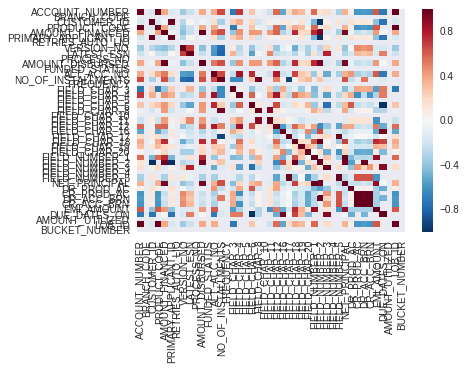

In [126]:
corr = df.corr()
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values)

In [127]:
df.corr()

,ACCOUNT_NUMBER,BRANCH_CODE,CUSTOMER_ID,PRODUCT_CODE,AMOUNT_FINANCED,PRIMARY_APPLICANT_ID,RETRIES_AUTO_LIQ,VERSION_NO,LATEST_ESN,PROCESS_NO,...,NET_PRINCIPAL,DR_PROD_AC,CR_PROD_AC,DR_ACC_BRN,CR_ACC_BRN,EMI_AMOUNT,DUE_DATES_ON,AMOUNT_UTILIZED,LOB_ID,BUCKET_NUMBER
ACCOUNT_NUMBER,1.000000,NaN,-0.165955,0.999949,0.389113,-0.165955,NaN,-0.365276,-0.220031,NaN,...,0.354630,0.074359,-0.588734,-0.568633,-0.586924,0.621572,-0.717650,NaN,0.999949,NaN
BRANCH_CODE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CUSTOMER_ID,-0.165955,NaN,1.000000,-0.168259,-0.059683,1.000000,NaN,-0.276037,0.019734,NaN,...,-0.133344,0.159899,0.093869,0.112993,0.095792,-0.398952,-0.733389,NaN,-0.168259,NaN
PRODUCT_CODE,0.999949,NaN,-0.168259,1.000000,0.384074,-0.168259,NaN,-0.361112,-0.214494,NaN,...,0.350818,0.069007,-0.587756,-0.568445,-0.586005,0.621572,NaN,NaN,1.000000,NaN
AMOUNT_FINANCED,0.389113,NaN,-0.059683,0.384074,1.000000,-0.059683,NaN,-0.410586,-0.240010,NaN,...,0.952465,-0.084700,-0.237397,-0.180029,-0.233789,0.437415,-0.017488,NaN,0.384074,NaN
PRIMARY_APPLICANT_ID,-0.165955,NaN,1.000000,-0.168259,-0.059683,1.000000,NaN,-0.276037,0.019734,NaN,...,-0.133344,0.159899,0.093869,0.112993,0.095792,-0.398952,-0.733389,NaN,-0.168259,NaN
RETRIES_AUTO_LIQ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
VERSION_NO,-0.365276,NaN,-0.276037,-0.361112,-0.410586,-0.276037,NaN,1.000000,0.689767,NaN,...,-0.391223,0.006099,0.479240,0.438019,0.475999,-0.149094,-0.178492,NaN,-0.361112,NaN
LATEST_ESN,-0.220031,NaN,0.019734,-0.214494,-0.240010,0.019734,NaN,0.689767,1.000000,NaN,...,-0.286646,-0.180859,0.327884,0.280298,0.324457,-0.140995,0.512107,NaN,-0.214494,NaN
PROCESS_NO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The above built in functions show that there is strong corelation between some variables (i.e. AMOUNT_FINANCED and AMOUNT_DISBURSED) .. it also shows that there variables with NaN correlation (i.e. BRANCH_CODE) that is non sense to calc. their linear relationship with the other variables .. finally, there is a weak correlation between set of variables .. i.e. CUSTOMER_ID and FIELD_NUMBER_5

## Plotting .. 

### AMOUNT_FINANCED .. 

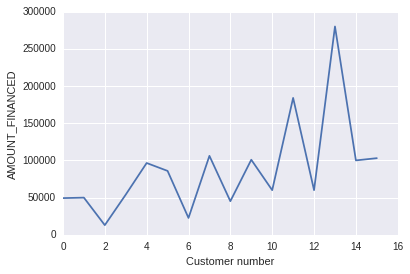

In [128]:
plt.plot(df['AMOUNT_FINANCED'])
plt.xlabel("Customer number")
plt.ylabel("AMOUNT_FINANCED")

The above figure is misleading .. as it doesn't tell about the skewness of the plot .. 

let's replace it with histogram ..

(array([ 2.,  6.,  1.,  5.,  0.,  0.,  1.,  0.,  0.,  1.]),
 array([  12969.56 ,   39672.604,   66375.648,   93078.692,  119781.736,
         146484.78 ,  173187.824,  199890.868,  226593.912,  253296.956,
         280000.   ]),
 <a list of 10 Patch objects>)

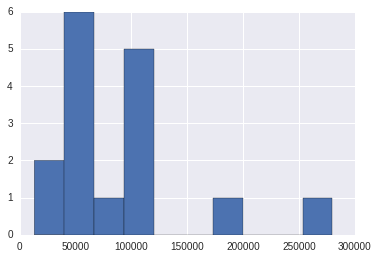

In [129]:
plt.hist(df['AMOUNT_FINANCED'])

The histogram above is meaningful .. it shows that the data is +ve skewed .. the majority of the customers have amounts in the 1st bin .. small portion have amounts higher than 1 billion .. 

This matches the values of mean and median calculated earlier .. (mean value is higher than the median) .. 

### AMOUNT_DISBURSED:

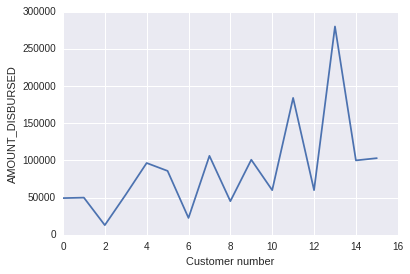

In [130]:
plt.plot(df['AMOUNT_DISBURSED'])
plt.xlabel("Customer number")
plt.ylabel("AMOUNT_DISBURSED")

(array([ 2.,  6.,  1.,  5.,  0.,  0.,  1.,  0.,  0.,  1.]),
 array([  12969.56 ,   39672.604,   66375.648,   93078.692,  119781.736,
         146484.78 ,  173187.824,  199890.868,  226593.912,  253296.956,
         280000.   ]),
 <a list of 10 Patch objects>)

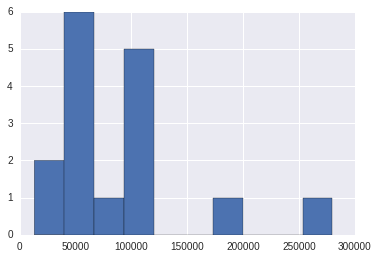

In [131]:
plt.hist(df['AMOUNT_DISBURSED'])

As expected .. the AMOUNT_FINANCED is stongly correlated with the AMOUNT_DISBURSED .. and this is confirmed through the matching plots .. 

### Let's plot ALL the numerical variables in one shot !

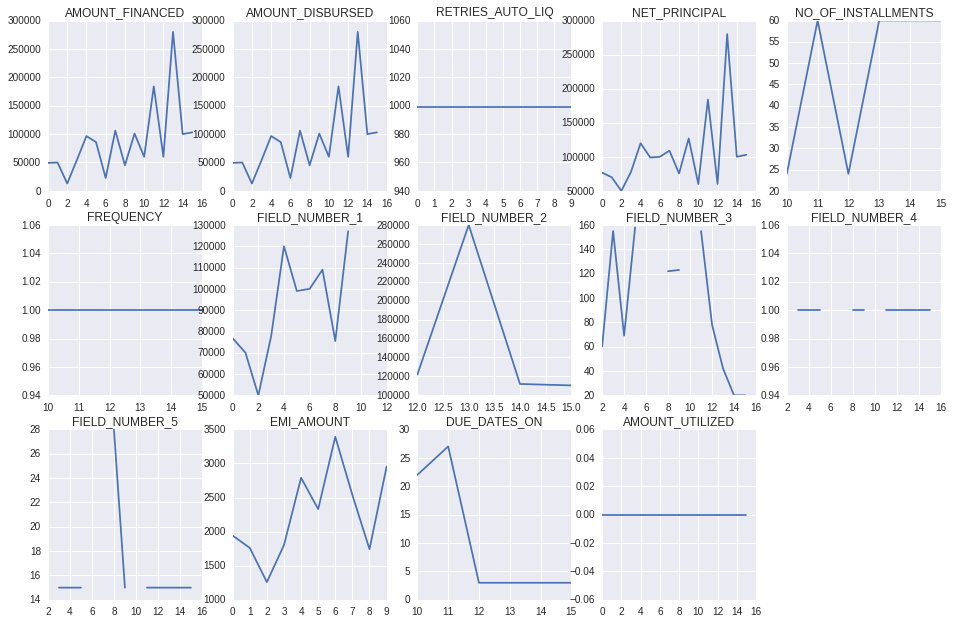

In [132]:
fig = plt.figure(figsize=(16, 80))
numeric_cols = ['AMOUNT_FINANCED', 'AMOUNT_DISBURSED', 'RETRIES_AUTO_LIQ', 'NET_PRINCIPAL', 'NO_OF_INSTALLMENTS', 
                'FREQUENCY', 'FIELD_NUMBER_1', 'FIELD_NUMBER_2', 'FIELD_NUMBER_3', 'FIELD_NUMBER_4', 'FIELD_NUMBER_5', 
                'EMI_AMOUNT', 'DUE_DATES_ON', 'AMOUNT_UTILIZED']

plot_count = 0
for numeric_col in numeric_cols:
    plot_count += 1
    plt.subplot(22, 5, plot_count)
    sns.plt.plot(numeric_col, data=df)
    plt.title(numeric_col)

In [133]:
df['STATUS_CHANGE_MODE'].unique()

array([u'A'], dtype=object)

## Comment:

Exploring April data is still not done as I don't have access to April data yet .. 

## Filling in the missing values .. 

As shown earlier .. the data contain lots of NAs .. we already removed the columns that are all NAs .. however, we can't remove the NAs rows from the rest of the columns as their count is huge (i.e. 3000+ out of 6000+) .. hence, let's replace NAs of numerical variables by the mean value and of the categorical variables by the mode .. 

In [134]:
## although these are int .. I gonna fill them by the mode just becuase these are mainly codes .. 
cols_int = ['BRANCH_CODE',  'CUSTOMER_ID',
  'PRIMARY_APPLICANT_ID',
  'VERSION_NO',
  'LATEST_ESN',
  'PROCESS_NO',
  'FUNDED_STATUS',
  'DR_PROD_AC',
  'CR_PROD_AC',
  'DR_ACC_BRN',
  'CR_ACC_BRN',
  'LOB_ID',
  'BUCKET_NUMBER']

# df[cols_int] = df[cols_int].fillna(df[cols_int].mode())
# df[cols_int].head()

df[cols_int] = df[cols_int].apply(lambda x:x.fillna(x.value_counts().index[0]))
df[cols_int].head()

,BRANCH_CODE,CUSTOMER_ID,PRIMARY_APPLICANT_ID,VERSION_NO,LATEST_ESN,PROCESS_NO,FUNDED_STATUS,DR_PROD_AC,CR_PROD_AC,DR_ACC_BRN,CR_ACC_BRN,LOB_ID,BUCKET_NUMBER
0,13,100489406,100489406,28,812,1,1000,392830002674,392830002674,39,39,302,0
1,13,100516179,100516179,30,715,1,1000,3122830007218,3122830007218,312,312,302,0
2,13,100373066,100373066,8,211,1,1000,132830001932,132830001932,13,13,302,0
3,13,100488216,100488216,27,808,1,1000,391430007861,391430007861,39,39,305,0
4,13,23671501,23671501,28,509,1,1000,132830014472,132830014472,13,13,305,0


In [135]:
## floats .. 

cols_float = ['AMOUNT_FINANCED',
  'RETRIES_AUTO_LIQ',
  'AMOUNT_DISBURSED',
  'FIELD_CHAR_3',
  'FIELD_CHAR_4',
  'FIELD_CHAR_8',
  'FIELD_CHAR_11',
  'FIELD_NUMBER_1',
  'FIELD_NUMBER_3',
  'FIELD_NUMBER_4',
  'FIELD_NUMBER_5',
  'NET_PRINCIPAL',
  'EMI_AMOUNT',
  'AMOUNT_UTILIZED']

df[cols_float] = df[cols_float].fillna(df[cols_float].median())
df[cols_float].head()

,AMOUNT_FINANCED,RETRIES_AUTO_LIQ,AMOUNT_DISBURSED,FIELD_CHAR_3,FIELD_CHAR_4,FIELD_CHAR_8,FIELD_CHAR_11,FIELD_NUMBER_1,FIELD_NUMBER_3,FIELD_NUMBER_4,FIELD_NUMBER_5,NET_PRINCIPAL,EMI_AMOUNT,AMOUNT_UTILIZED
0,49310.71,999,49310.71,5,136,21,60,76800,78,1,15,76800,1942.62,0
1,49971.58,999,49971.58,5,136,21,60,70000,78,1,15,70000,1761.47,0
2,12969.56,999,12969.56,5,136,21,60,50000,60,1,15,50000,1259.73,0
3,53974.92,999,53974.92,3,124,21,60,77800,155,1,15,77800,1802.93,0
4,96499.10,999,96499.10,3,122,28,60,120000,69,1,15,120000,2790.38,0


In [136]:
## categorical variables .. 

cols_cat = ['ACCOUNT_NUMBER',
  'APPLICATION_NUM',
  'PRODUCT_CODE',
  'PRODUCT_CATEGORY',
  'CURRENCY',
  'PRIMARY_APPLICANT_NAME',
  'USER_DEFINED_STATUS',
  'CALC_REQD',
  'AUTO_MAN_ROLLOVER',
  'SCHEDULE_BASIS',
  'UDE_ROLLOVER_BASIS',
  'ROLLOVER_TYPE',
  'RATE_CODE_PREF',
  'PASSBOOK_FACILITY',
  'ATM_FACILITY',
  'ALLOW_BACK_PERIOD_ENTRY',
  'INT_STMT',
  'TRACK_RECEIVABLE_ALIQ',
  'TRACK_RECEIVABLE_MLIQ',
  'LIQUIDATION_MODE',
  'AMEND_PAST_PAID_SCHEDULE',
  'CHEQUE_BOOK_FACILITY',
  'LIQ_BACK_VALUED_SCHEDULES',
  'LIQ_COMP_DATES_FLAG',
  'ACCOUNT_STATUS',
  'AUTH_STAT',
  'STOP_ACCRUALS',
  'AMORTIZED',
#  'RECALC_ACTION_CODE',
  'MAKER_ID',
  'CHECKER_ID',
  'ARVN_APPLIED',
  'ALT_ACC_NO',
  'PARTIAL_LIQUIDATION',
  'ALIQ_REVERSED_PMT',
  'FREQUENCY_UNIT',
  'FIRST_INS_DATE',
  'FIELD_CHAR_1',
  'FIELD_CHAR_2',
  'FIELD_CHAR_5',
  'FIELD_CHAR_6',
  'FIELD_CHAR_9',   
  'FIELD_CHAR_12',
  'FIELD_CHAR_10',
  'FIELD_CHAR_14',
  'FIELD_CHAR_15',
  'FIELD_CHAR_16',
  'FIELD_CHAR_17',
  'FIELD_CHAR_18',
  'FIELD_CHAR_19',
  'FIELD_CHAR_20',
  'FIELD_DATE_7',
  'ROLL_BY',
  'MATURITY_TYPE',
  'DR_PAYMENT_MODE',
  'CR_PAYMENT_MODE',
  'CUTOFF_TRANSACTION',
  'DELINQUENCY_STATUS',
  'USER_REF_NO',
  'ROLLOVER_ALLOWED',
  'COMMITMENT_TYPE',
  'LOAN_TYPE',
  'MODULE_CODE',
  'PACKING_CREDIT',
  'LEASE_PAYMENT_MODE',
 # 'ALLOW_BULK_PAYMNET',
 # 'STOP_DSBR',
 # 'INTERMEDIARY_INITIATED',
  #'NOTARY_AUTO_CONFIRMED',
 # 'RECALC_ANNUITY',
  'LOAN_STMT_REQD',
  'SUBSYSTEMSTAT',
#  'USE_GUARANTOR',
  'LOAN_AGAINST_SAL',
 # 'FIRST_PAY_BY_DATE',
  'OPEN_LINE_LOAN',
  'REVOLVING_TYPE',
  'PROJECT_ACCOUNT',
  'HANDOVER_CONF',
  'LOAN_STLMNT_NOTICEFLG',
  'AUTO_CLOSE_COLLATERAL',
  'STATUS_CHANGE_MODE',
  'RATE_CHG_ACTION',
  'REC_STATUS']

# df[cols_cat].fillna(df[cols_cat].mode())  # ya3ni delw2ty el O NAs mish bettmeli 
df[cols_cat] = df[cols_cat].apply(lambda x:x.fillna(x.value_counts().index[0]))
df[cols_cat].head()

,ACCOUNT_NUMBER,APPLICATION_NUM,PRODUCT_CODE,PRODUCT_CATEGORY,CURRENCY,PRIMARY_APPLICANT_NAME,USER_DEFINED_STATUS,CALC_REQD,AUTO_MAN_ROLLOVER,SCHEDULE_BASIS,...,LOAN_AGAINST_SAL,OPEN_LINE_LOAN,REVOLVING_TYPE,PROJECT_ACCOUNT,HANDOVER_CONF,LOAN_STLMNT_NOTICEFLG,AUTO_CLOSE_COLLATERAL,STATUS_CHANGE_MODE,RATE_CHG_ACTION,REC_STATUS
0,130701153020020,H0013701131004,701,RETAIL_AUTO_LOANS,EGP,HEBA271183,BKT3,N,M,P,...,N,N,N,N,N,N,N,A,E,U
1,130701153020033,H0013701131006,701,RETAIL_AUTO_LOANS,EGP,IBRAHIM130272,NORM,N,M,P,...,N,N,N,N,N,N,N,A,E,S
2,130701153020034,H0013701111008,701,RETAIL_AUTO_LOANS,EGP,ADEL240778,NORM,N,M,P,...,N,N,N,N,N,N,N,A,E,S
3,130702153020004,H0013702131004,702,RETAIL_AUTO_LOANS,EGP,MAHMOUD240687,BKT5,N,M,P,...,N,N,N,N,N,N,N,A,E,U
4,130702153020005,H0013702141002,702,RETAIL_AUTO_LOANS,EGP,AHMED181079,NORM,N,M,P,...,N,N,N,N,N,N,N,A,E,U


In [137]:
df.isnull().any()

ACCOUNT_NUMBER              False
BRANCH_CODE                 False
APPLICATION_NUM             False
CUSTOMER_ID                 False
PRODUCT_CODE                False
PRODUCT_CATEGORY            False
BOOK_DATE                   False
VALUE_DATE                  False
MATURITY_DATE               False
AMOUNT_FINANCED             False
CURRENCY                    False
ORIGINAL_ST_DATE            False
PRIMARY_APPLICANT_ID        False
PRIMARY_APPLICANT_NAME      False
USER_DEFINED_STATUS         False
CALC_REQD                   False
AUTO_MAN_ROLLOVER           False
SCHEDULE_BASIS              False
UDE_ROLLOVER_BASIS          False
ROLLOVER_TYPE               False
RATE_CODE_PREF              False
PASSBOOK_FACILITY           False
ATM_FACILITY                False
ALLOW_BACK_PERIOD_ENTRY     False
INT_STMT                    False
TRACK_RECEIVABLE_ALIQ       False
TRACK_RECEIVABLE_MLIQ       False
LIQUIDATION_MODE            False
AMEND_PAST_PAID_SCHEDULE    False
CHEQUE_BOOK_FA

## Comment:
LOAN_TO_VALUE is still have NAs .. let's check it again .. 

In [138]:
# df['LOAN_TO_VALUE'].isnull().sum()

:) Single cell has value .. let's remove the whole column .. 

In [139]:
# df = df.drop('LOAN_TO_VALUE', 1)

In [140]:
# df.head()

## Data Transformation:

As the data contains many categorical variables .. these variables will generate error while being converted to tensors (in LSTM algorithm) .. due to the disability of converting them to float32 ! .. 

I have to convert those categorical variables into numerical ones .. i.e. LOAN_STLMNT_NOTICEFLG ==> N: 0 and Y: 1

Let's start with the columns represent IDs .. i.e ACCOUNT_NUMBER or APPLICATION_NUM .. 

In [141]:
## APPLICATION_NUM 
df[cols_cat[1]] = pd.Categorical((pd.factorize(df[cols_cat[1]])[0] + 1).astype(str))
df[cols_cat[1]].head()

0    1
1    2
2    3
3    4
4    5
Name: APPLICATION_NUM, dtype: category
Categories (10, object): [1, 10, 2, 3, ..., 6, 7, 8, 9]

For simplecity .. let's iterate over the whole categoical columns

In [142]:
for i in xrange(len(cols_cat)):
    df[cols_cat[i]] = pd.Categorical((pd.factorize(df[cols_cat[i]])[0] + 1).astype(str))
    
df[cols_cat].head()

,ACCOUNT_NUMBER,APPLICATION_NUM,PRODUCT_CODE,PRODUCT_CATEGORY,CURRENCY,PRIMARY_APPLICANT_NAME,USER_DEFINED_STATUS,CALC_REQD,AUTO_MAN_ROLLOVER,SCHEDULE_BASIS,...,LOAN_AGAINST_SAL,OPEN_LINE_LOAN,REVOLVING_TYPE,PROJECT_ACCOUNT,HANDOVER_CONF,LOAN_STLMNT_NOTICEFLG,AUTO_CLOSE_COLLATERAL,STATUS_CHANGE_MODE,RATE_CHG_ACTION,REC_STATUS
0,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
1,2,2,1,1,1,2,2,1,1,1,...,1,1,1,1,1,1,1,1,1,2
2,3,3,1,1,1,3,2,1,1,1,...,1,1,1,1,1,1,1,1,1,2
3,4,4,2,1,1,4,3,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4,5,5,2,1,1,5,2,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [143]:
df[cols_cat[24]].head()

0    1
1    2
2    2
3    1
4    1
Name: ACCOUNT_STATUS, dtype: category
Categories (2, object): [1, 2]

the order unique values of account_status ==> 'V', 'L', 'A', 'I', 'H' .. Hence, V is represented by 1, L ==> 2 .. 

Let's do the same conversion to date variables as well as int variables (as mentioned, they represent codes) ..

In [144]:
for i in xrange(len(cols_date)):
    df[cols_date[i]] = pd.Categorical((pd.factorize(df[cols_date[i]])[0] + 1).astype(str))
    
df[cols_date].head()

,ORIGINAL_ST_DATE,FIELD_DATE_1,FIELD_DATE_2,FIELD_DATE_3,FIELD_DATE_7,FIELD_DATE_8,FIELD_DATE_9,FIELD_DATE_10,MIGRATION_DATE,AS_OF_DATE,EXTRACTION_DATE,CHECKER_DT_STAMP,MAKER_DT_STAMP,ORIGINAL_ST_DATE,BOOK_DATE,VALUE_DATE,MATURITY_DATE
0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
1,2,2,2,2,2,2,2,2,1,1,2,2,2,2,1,1,2
2,3,3,3,3,3,3,3,3,1,1,2,3,1,3,1,2,3
3,4,4,4,4,4,4,4,4,1,1,3,4,3,4,1,3,4
4,5,5,5,5,5,5,5,5,1,1,4,5,4,5,1,4,5


In [145]:
for i in xrange(len(cols_int)):
    df[cols_int[i]] = pd.Categorical((pd.factorize(df[cols_int[i]])[0] + 1).astype(str))
    
df[cols_int].head()

,BRANCH_CODE,CUSTOMER_ID,PRIMARY_APPLICANT_ID,VERSION_NO,LATEST_ESN,PROCESS_NO,FUNDED_STATUS,DR_PROD_AC,CR_PROD_AC,DR_ACC_BRN,CR_ACC_BRN,LOB_ID,BUCKET_NUMBER
0,1,1,1,1,1,1,1,1,1,1,1,1,1
1,1,2,2,2,2,1,1,2,2,2,2,1,1
2,1,3,3,3,3,1,1,3,3,3,3,1,1
3,1,4,4,4,4,1,1,4,4,1,1,2,1
4,1,5,5,1,5,1,1,5,5,3,3,2,1


## LSTM .. 

- RNN - LSTM is used maily to learn the next states from the observations

- Long Short Term Memory networks “LSTMs” is implemented 


## Why RNN ?!
1. Becuase traditional neural network ignores the previous experience every time directly after generating the output and starts the learning process again from scratch .. RNN doesn't (is able to connect previous information to the present task) !  

2. One big problem with traditional RNNs is the vanishing (or exploding) gradient problem where, depending on the activation functions used, information rapidly gets lost over time.

3. LSTM-RNN tries to combat the vanishing / exploding gradient problem by introducing gates and an explicitly defined memory cell. These are inspired mostly by circuitry, not so much biology.

4. Becuase it is used by the comparable paper (LSTM-RNN)

5. SLTM can model long-term dependency in a customer’s interaction history.


- Tutorial for LSTM RNN ==> http://colah.github.io/posts/2015-08-Understanding-LSTMs/

## Implementation layout: 
- We have three main types of gates each of which consists of three types of nodes 
    1. Input Gate:
          - Input node
          - Previous output
          - Bias
    2. Forget Gate:
          - Input node
          - Previous output
          - Bias
    3. Output Gate: 
          - Input node
          - Previous output
          - Bias
          
    4. Finally, we have one extra cell called (Memory cell) consists of three nodes as well 
          - Input node
          - State
          - Bias
          

- We also have (saved_output, saved_state, w, b)

In [146]:
## correlation .. 
df['NET_PRINCIPAL'].corr(df['AMOUNT_FINANCED']), df['EMI_AMOUNT'].corr(df['AMOUNT_FINANCED'])

(0.9524654305820931, 0.1113514274612258)

## Comment:

As stated earlier the reward of the customer is his balance in the bank .. 

As we have a lot of columns represent this balance i.e. AMOUNT_FINANCED, AMOUNT_DISBURSED, EMI_AMOUNT and NET_PRINCIPAL .. and many more .. however, only those four are valid (Not NAs and don't contain many missing values) .. 

However as there is a strong correlation between AMOUNT_FINANCED, AMOUNT_DISBURSED .. only one of them might be used .. 

Hence, the reward is represented by [AMOUNT_FINANCED, EMI_AMOUNT, NET_PRINCIPAL] ..

The current state .. is the whole record of the customer (except the above three columns) .. 

__NOTE__:

- I think it makes more sense to represent the state of the customer only by the fields representing his (Recency, Frequancy, Monetary) status .. however, just becuase they are not directly extracted and just for simplicity .. let's make his state is his whole record (if the column is only NAs .. it is excluded) .. 

- The next state is the whole record of the customer as well but for April data instead of March .. (as we don't have march's data .. let's assume that next state is also March's data .. )

- There is a column named 'STATUS_CHANGE_MODE' with only value of 'A' .. this means (Automatic) .. I will not consider this as an action .. but 'ACCOUNT_STATUS' .. that contains 'A', 'I' and other values represent the status of the account (active, inactive ...) .. As it contains 5 unique values .. I have 5 different actions for the customers .. 

In [147]:
current_states = df[df.columns.difference(['AMOUNT_FINANCED', 'EMI_AMOUNT', 'ACCOUNT_STATUS', 'ACCOUNT_NUMBER', 'FIELD_CHAR_13'])]
# ACCOUNT_NUMBER is removed cuase it cuased problem while reading it in LSTM .. 

curr_state_current_action = pd.DataFrame(np.column_stack((current_states, df['ACCOUNT_STATUS'])))

## Rewards
## let assume the rewards are only AMOUNT_FINANCED not  rewards = ['AMOUNT_FINANCED', 'EMI_AMOUNT']
rewards = ['AMOUNT_FINANCED']
for i in xrange(len(rewards)):
    df[rewards[i]] = pd.Categorical((pd.factorize(df[rewards[i]])[0] + 1).astype(str))
    
## next states 
next_states = current_states[:16]

## next actions 
next_actions = np.zeros([len(next_states), max(df['ACCOUNT_STATUS'].unique().astype(int)) + 1])

next_actions[np.arange(next_actions.shape[0])[:], df['ACCOUNT_STATUS'].astype(int)] = 1 ## extra column 
next_actions = np.delete(next_actions, 0, 1)  # to drop the 1st column that is all zeros .. 

## next_state_next_action 
next_state_current_action1 = pd.DataFrame(np.column_stack((next_states, next_actions[:, 0])))

next_state_current_action2 = pd.DataFrame(np.column_stack((next_states, next_actions[:, 1])))
next_state_current_action2


,0,1,2,3,4,5,6,7,8,9,...,109,110,111,112,113,114,115,116,117,118
0,1,1,1,1,1,49310.7,0,1,1,1,...,1,1,1,1,1,1,1,1,1,0
1,1,1,2,1,1,49971.6,0,2,1,1,...,1,1,1,1,1,2,2,1,2,1
2,1,1,3,1,1,12969.6,0,3,1,1,...,1,1,1,1,1,2,3,2,3,1
3,1,1,4,1,1,53974.9,0,4,1,1,...,1,1,1,1,1,3,4,3,4,0
4,1,1,5,1,1,96499.1,0,5,1,1,...,1,1,1,1,1,2,5,4,1,0
5,1,1,6,1,1,85873.3,0,6,1,1,...,1,1,1,1,1,2,6,4,5,0
6,1,1,7,1,1,22653.4,0,7,1,1,...,1,1,1,1,1,2,7,4,6,1
7,1,1,8,1,1,106117,0,8,1,1,...,1,1,1,1,1,2,8,1,7,0
8,1,1,9,1,1,45150,0,9,1,1,...,1,1,1,1,1,2,9,4,8,1
9,1,1,10,1,1,100886,0,10,1,1,...,1,1,1,1,1,2,10,5,9,0


Columns names are not mapped correctly in the new generated dataframes .. 

In [148]:
current_states = current_states.values  # convert pandas to numpy array 
curr_state_current_action = curr_state_current_action.values
next_states = next_states.values
next_state_current_action1 = next_state_current_action1.values
next_state_current_action2 = next_state_current_action2.values

Check Nan ! .. 

In [149]:
for i in current_states:
    if i.any() == 'nan':
        print "yes"

non of the converted dataframes contain nan .. 

## Variables initialization:

In [294]:
gamma = 0.8
Num_itrs = 10

num_epoch = 10 #epochs are cycles of Feedforward and Backprob
batch_size = 10
n_nodes_hl1 = np.shape(curr_state_current_action)[0]
n_nodes_hl2 = np.shape(curr_state_current_action)[0]
NUM_STATES = np.shape(curr_state_current_action)[1]
NUM_DIM =  np.shape(current_states)[1]
num_nodes = np.shape(curr_state_current_action)[0]
num_unrollings=5

Q = np.zeros([np.shape(curr_state_current_action)[0],2])
reshaped_Q = np.zeros([np.shape(curr_state_current_action)[0],2])

## Create Placeholders:

In [151]:
x = tf.placeholder(tf.float32, shape=[NUM_DIM, num_nodes])
y =  tf.placeholder(tf.float32, shape=[NUM_DIM, num_nodes])
y

<tf.Tensor 'Placeholder_3:0' shape=(118, 16) dtype=float32>

## Sequence to sequence RNN:

https://indico.io/blog/sequence-modeling-neuralnets-part1/ 

- Basic RNNs take each element of a sequence, multiply the element by a matrix, and then sum the result with the previous output from the network.

- To use an RNN for a language model, we take the input sequence from t=1 to t=sequence_length – 1 and try to predict the same sequence from t=2 to t=sequence_length. Since the RNN’s output is based on all previous inputs of the sequence, its output can be be expressed as Yt = g ( f (Yt-1 , Yt-2 , …Yt1 )). The function f gives the next state of the RNN, while the function g maps the state of the RNN to a value in our target vocabulary. Put simply, f gives a hidden state of the network, while g gives the output of the network – much like a softmax layer in a simple neural network.

- Sequence to sequence models build on top of language models by adding an encoder step and a decoder step. In the encoder step, a model converts an input sequence (such as an English sentence) into a fixed representation. In the decoder step, a language model is trained on both the output sequence (such as the translated sentence) as well as the fixed representation from the encoder. Since the decoder model sees an encoded representation of the input sequence as well as the translation sequence, it can make more intelligent predictions about future words based on the current word.

==> Thus, 
* Inputs: read current states
* Outputs: read next states .. w el estimated output = [nodes, num_states]
* hidden: recurrent 3adi !

## Init weights:

- Truncated_normal ==> Outputs random values from a truncated normal distribution. The generated values follow a normal distribution with specified mean and standard deviation, except that values whose magnitude is more than 2 standard deviations from the mean are dropped and re-picked.

- The cost results were the same values however, they were changed once the range of value in trucnated normal function changed from (-0.1 to 0.1) to (0 to 1)

In [152]:
# Input gate: input, previous output, and bias.
ix = tf.Variable(tf.truncated_normal([NUM_DIM, num_nodes], 0, 1, dtype = tf.float32))# init_weights_RNN([n_nodes_hl1, NUM_ACTIONS])
im = tf.Variable(tf.truncated_normal([num_nodes, num_nodes], 0, 1, dtype = tf.float32))
ib = tf.Variable(tf.zeros([1, num_nodes], dtype = tf.float32))

# Forget gate: input, previous output, and bias.
fx = tf.Variable(tf.truncated_normal([NUM_DIM, num_nodes], 0, 1, dtype = tf.float32))
fm = tf.Variable(tf.truncated_normal([num_nodes, num_nodes], 0, 1, dtype = tf.float32))
fb = tf.Variable(tf.zeros([1, num_nodes], dtype = tf.float32))

# Memory cell: input, state and bias.                             
cx = tf.Variable(tf.truncated_normal([NUM_DIM, num_nodes], 0, 1, dtype = tf.float32))
cm = tf.Variable(tf.truncated_normal([num_nodes, num_nodes], 0, 1, dtype = tf.float32))
cb = tf.Variable(tf.zeros([1, num_nodes], dtype = tf.float32))

# Output gate: input, previous output, and bias.
ox = tf.Variable(tf.truncated_normal([NUM_DIM, num_nodes], 0, 1, dtype = tf.float32))
om = tf.Variable(tf.truncated_normal([num_nodes, num_nodes], 0, 1, dtype = tf.float32))
ob = tf.Variable(tf.zeros([1, num_nodes], dtype = tf.float32))

# Variables saving state across unrollings.
saved_output = tf.Variable(tf.zeros([NUM_DIM, num_nodes], dtype = tf.float32), trainable=False) #reversed

saved_state = tf.Variable(tf.zeros([NUM_DIM, num_nodes], dtype = tf.float32), trainable=False) #reversed

# Classifier weights and biases.
w = tf.Variable(tf.truncated_normal([num_nodes, num_nodes], 0, 1, dtype = tf.float32))
b = tf.Variable(tf.zeros([num_nodes], dtype = tf.float32))

## Building the model:

In [153]:
 # Definition of the cell computation.
# this method takes single cell and returns single number 
def lstm_cell(i, o, state):
    input_gate = tf.sigmoid(tf.matmul(i, ix) + tf.matmul(o, im) + ib)
    forget_gate = tf.sigmoid(tf.matmul(i, fx) + tf.matmul(o, fm) + fb)
    update = tf.matmul(i, cx) + tf.matmul(o, cm) + cb
    state = forget_gate * state + input_gate * tf.tanh(update)
    output_gate = tf.sigmoid(tf.matmul(i, ox) + tf.matmul(o, om) + ob)
    return output_gate * tf.tanh(state), state

In [154]:
def lstm_model(current_states, saved_output, saved_state):
# Unrolled LSTM loop.    
    outputs = list()
    output = saved_output
    state = saved_state
    
    # astype('U') .. to convert numpy array to string ..
    for i in xrange(np.shape(current_states)[0]):## el loop faydetha to copy the next line that is just for single unit 
        output_, state = lstm_cell(tf.string_to_number(current_states[i, None].astype('U')), tf.cast(output, tf.float32), tf.cast(state, tf.float32)) 

    ## in case the last values are saved !
    with tf.control_dependencies([saved_output.assign(output), saved_state.assign(state)]):
        model_output = tf.matmul(output_, w) + b # outputs single value
        
    return model_output  ## the output for the whole model

## Model training evaluation:
elli ana fahmah now, enn el RNN input is the current observation and the output is the next observations .. as if Inputs are sequance of values and outputs is also deq of values

In [155]:
def train_lstm_model():
    loss_RNN = []
    model_output = lstm_model(current_states, saved_output, saved_state) #output here is a vector
    cost = tf.reduce_mean(tf.square(y - model_output))
    train_op = tf.train.GradientDescentOptimizer(0.005).minimize(cost) 
    
    sess = tf.Session()
    init = tf.global_variables_initializer()  ## updated version from initialize_all_variables :) 
    sess.run(init)
    output__ = sess.run(model_output, feed_dict={x:np.transpose(current_states), y: np.transpose(next_states)})
    
#     ## Cost calculation
    for step in xrange(100):
        l,_ = sess.run([cost, train_op], feed_dict={x:np.transpose(current_states), y: np.transpose(next_states)})
        
        if step % 10 == 0:
            loss_RNN.append(l)
    
    sess.close()
    return loss_RNN, output__ #saved_state, saved_output, cost_values

In [156]:
loss_RNN, output__ = train_lstm_model()

In [157]:
output__

array([[ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       ..., 
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan]], dtype=float32)

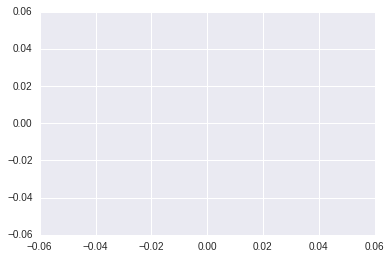

In [158]:
plt.plot(loss_RNN)

## Learning the rewards:
Now, the LSTM_RNN output is considered as next_state for DQN model

https://arxiv.org/pdf/1602.01580.pdf

## Multilayer Deep Neural Network (DQN):

In [159]:
output__ = np.transpose(output__)
output__

array([[ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       ..., 
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan]], dtype=float32)

In [160]:
next_state_next_action1 = np.hstack((output__, np.zeros((output__.shape[0], 1), dtype=output__.dtype)))
next_state_next_action2 = np.hstack((output__, np.ones((output__.shape[0], 1), dtype=output__.dtype)))
np.shape(next_state_next_action1)

(16, 119)

## Data Normalization:

As the data points are already represented by categorical classes .. there might be no need to scale them again to minimize the gap between their values .. 

## Model Training:

In [395]:
def init_weights(shape):
    return tf.Variable(tf.random_normal(shape, stddev=1))

In [396]:
def DQN_model(X, w_h_1, w_h_2, w_o, bias_I_1, bias_I_2, bias_h):

    layer_1 = tf.matmul(X, w_h_1) + bias_I_1
    layer_1 = tf.nn.relu(layer_1)  ## el performance of softmax outperforms relu!!
    
    layer_2 = tf.matmul(layer_1, w_h_2) + bias_I_2
    layer_2 = tf.nn.sigmoid(layer_2) 

    py_x = tf.matmul(layer_2, w_o) + bias_h
    
    return py_x  #predicted output
    # note that we dont take the softmax at the end because our cost fn does that for us

In [524]:
def DQN_training(X, output):
 
    w_h_1 = init_weights([np.shape(X)[1], n_nodes_hl1]) # create symbolic variables\n",
    w_h_2 = init_weights([n_nodes_hl1, n_nodes_hl2]) # create symbolic variables\n",
    w_o = init_weights([n_nodes_hl2, 1])
    
    bias_I_1=init_weights([n_nodes_hl1])
    bias_I_2=init_weights([n_nodes_hl2])
    bias_h=init_weights([1])
    
    py_x = DQN_model(tf.cast(X, tf.float32), w_h_1, w_h_2, w_o,bias_I_1, bias_I_2,bias_h)  #model training  
        
    cost = tf.reduce_mean(tf.square(py_x - output)) # compute costs",  # excpect float32

    train_op = tf.train.GradientDescentOptimizer(0.05).minimize(cost) # construct an optimizer\n",
    
    sess = tf.Session()
    init = tf.global_variables_initializer()
    sess.run(init)
    
    sess.close()    
    return w_h_1, w_h_2, w_o,bias_I_1, bias_I_2,bias_h

In [542]:
## Prediction phase: 
def DQN_predict(next_state_next_action1, next_state_next_action2, output):

    [w_h_1, w_h_2, w_o,bias_I_1, bias_I_2,bias_h] = DQN_training(next_state_next_action1, output)

    predict_op_1 = DQN_model(next_state_next_action1.astype(np.float32), w_h_1, w_h_2, w_o,bias_I_1, bias_I_2,bias_h)
      
        
#     print next_state_next_action2     
    [w_h_1, w_h_2, w_o,bias_I_1, bias_I_2,bias_h] = DQN_training(next_state_next_action2, output)
    predict_op_2 = DQN_model(next_state_next_action2.astype(np.float32), w_h_1, w_h_2, w_o,bias_I_1, bias_I_2, bias_h)   #optimal prediction
    
    
    sess2 = tf.Session()
    init2 = tf.global_variables_initializer()
    sess2.run(init2)

    l1=sess2.run(predict_op_1)
    l2=sess2.run(predict_op_2)
    Q = [l1, l2]
    
    sess2.close()
    return np.transpose(Q)

In [548]:
# for j in xrange(Num_itrs):
output = map(sum, zip(df[rewards].values.astype(int),gamma*np.amax(reshaped_Q,axis = 1))) # returns max value per row !

output = np.array(output, dtype=np.float64)
output.astype(np.float32)

Q = DQN_predict(next_state_next_action1.astype(float), next_state_next_action2.astype(float), output)
reshaped_Q = Q.reshape(np.shape(curr_state_current_action)[0],2)


print("Total output is:", output)
print("Q fun. is: ", reshaped_Q)

('Total output is:', array([[ nan],
       [ nan],
       [ nan],
       [ nan],
       [ nan],
       [ nan],
       [ nan],
       [ nan],
       [ nan],
       [ nan],
       [ nan],
       [ nan],
       [ nan],
       [ nan],
       [ nan],
       [ nan]]))
('Q fun. is: ', array([[ nan,  nan],
       [ nan,  nan],
       [ nan,  nan],
       [ nan,  nan],
       [ nan,  nan],
       [ nan,  nan],
       [ nan,  nan],
       [ nan,  nan],
       [ nan,  nan],
       [ nan,  nan],
       [ nan,  nan],
       [ nan,  nan],
       [ nan,  nan],
       [ nan,  nan],
       [ nan,  nan],
       [ nan,  nan]], dtype=float32))
